In [2]:
# This code defines the images to be classified:
 
import numpy as np
 
# Total number of "pixels"/qubits
size = 8
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 2
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 2
 
 
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))
 
    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1
 
    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.
 
    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1
 
    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.
 
    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))
 
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select 0 or 1 for a horizontal or vertical array, assign the corresponding label.
 
        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels
 
 
hor_size = round(size / vert_size)

In [3]:
from sklearn.model_selection import train_test_split
 
np.random.seed(42)
images, labels = generate_dataset(200)
 
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

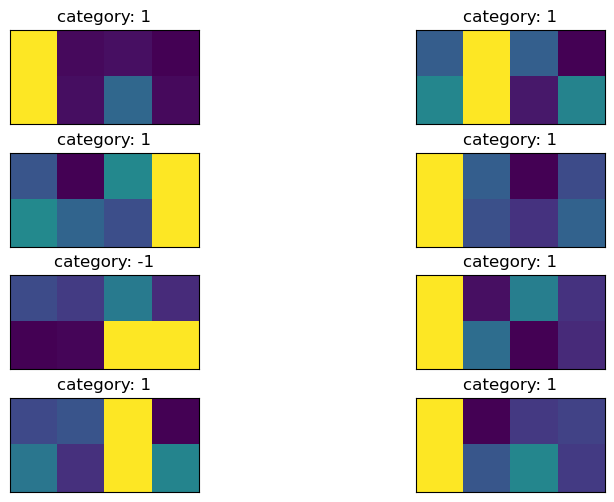

In [4]:
import matplotlib.pyplot as plt
 
# Make subplot titles so we can identify categories
titles = []
for i in range(8):
    title = "category: " + str(train_labels[i])
    titles.append(title)
 
# Generate a figure with nested images using subplots.
fig, ax = plt.subplots(4, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
 
for i in range(8):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(titles[i])
plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [6]:
from qiskit.circuit.library import ZFeatureMap
 
# One qubit per data feature
num_qubits = len(train_images[0])
 
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = ZFeatureMap(num_qubits, parameter_prefix="a")

5
2+ qubit depth: 3


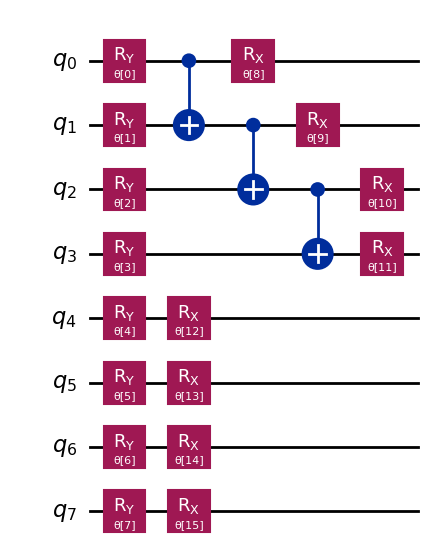

In [8]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
 
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Draw the circuit
qnn_circuit.draw("mpl")

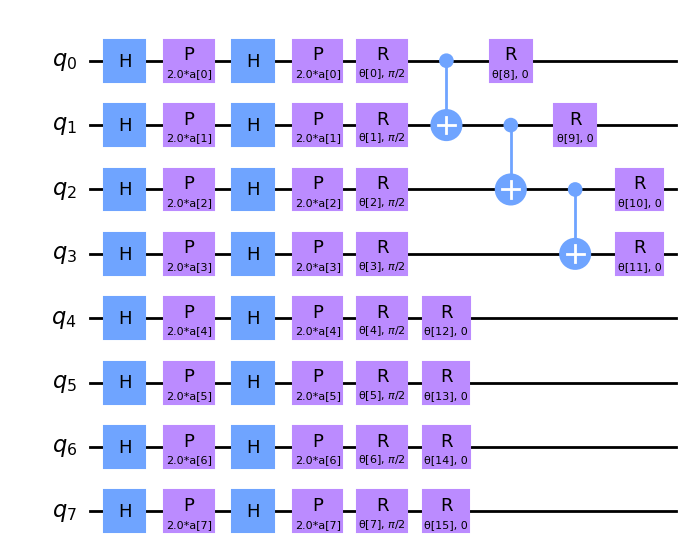

In [9]:
# QNN ansatz
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [10]:
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

In [11]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
 
 
def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
 
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.
 
    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
 
    return expectation_values

In [12]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).
 
    prediction: predictions from the forward pass of neural network.
    target: true labels.
 
    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

In [13]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.
 
    weight_params: ansatz parameters to be updated by the optimizer.
 
    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )
 
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
 
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1
 
    return cost

In [14]:
from scipy.optimize import minimize

In [15]:
# Globals
circuit = full_circuit
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)